In [2]:
import os
import cv2
import random
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.svm import SVC
from collections import deque
from imutils import face_utils
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [3]:
# Specify the directory and image file name
directory = "train/angry"
image_file = "Training_3908.jpg"  # Ensure the file extension is correct
image_path = os.path.join(directory, image_file)

# Check if the file exists
if os.path.exists(image_path):
    print(f"Image found at: {image_path}")
    # Open and display the image using PIL
    img = Image.open(image_path)
    img.show()  # Opens the image in the default image viewer
else:
    print(f"Image file not found: {image_path}")

Image found at: train/angry\Training_3908.jpg


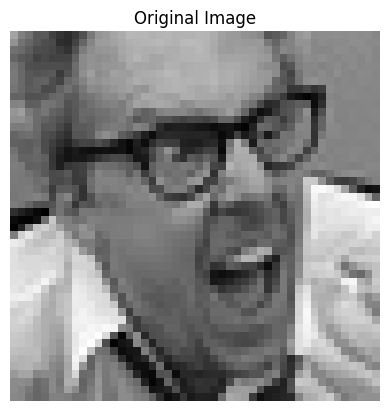

(48, 48, 3)


In [4]:
image = cv2.imread("train/angry/Training_3908.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis("off")  
plt.title("Original Image")
plt.show()
print(image.shape)

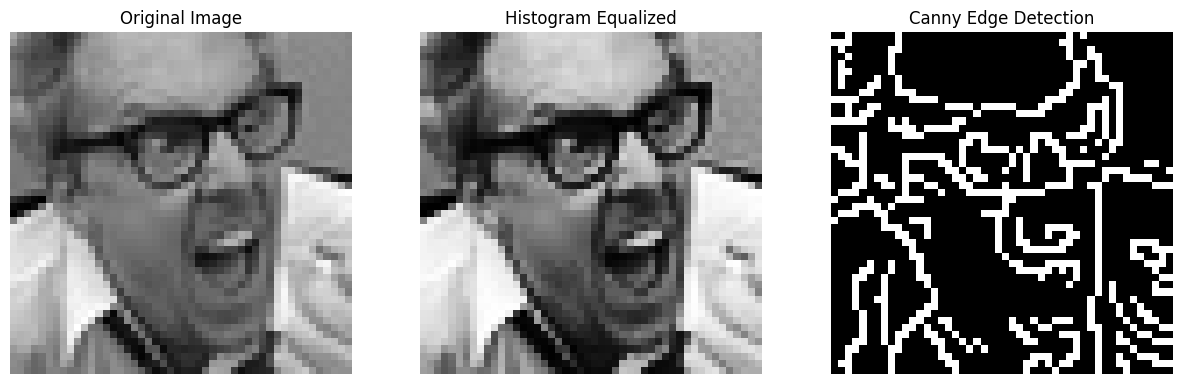

In [5]:
# Load Image
image = cv2.imread("train/angry/Training_3908.jpg", cv2.IMREAD_GRAYSCALE)

# Apply Histogram Equalization for contrast enhancement
equalized_image = cv2.equalizeHist(image)

# Apply Gaussian Blur for noise reduction
blurred_image = cv2.GaussianBlur(equalized_image, (3, 3), 0)

# Apply Edge Detection (Canny)
edges = cv2.Canny(blurred_image, 100, 200)

# Display Original and Processed Images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(equalized_image, cmap='gray')
axes[1].set_title("Histogram Equalized")
axes[1].axis("off")

axes[2].imshow(edges, cmap='gray')
axes[2].set_title("Canny Edge Detection")
axes[2].axis("off")

plt.show()


In [6]:
# Specify the directory and image file name
directory = "train/angry"
image_file = "Training_3908.jpg"  # Ensure the file extension is correct

# Construct the full path to the image
image_path = os.path.join(directory, image_file)

# Check if the file exists
if os.path.exists(image_path):
    print(f"Image found at: {image_path}")


Image found at: train/angry\Training_3908.jpg


In [7]:
def calculate_class_weights(dataset_path):
    class_counts = {}
    total_images = 0
    class_names = []

    # Iterate through each folder (class) and count images
    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if os.path.isdir(folder_path):
            image_count = len(os.listdir(folder_path))
            class_counts[folder] = image_count
            total_images += image_count
            class_names.append(folder)

    # Ensure consistent class order
    class_names.sort()
    class_indices = {name: idx for idx, name in enumerate(class_names)}

    # Create an array of labels corresponding to the dataset
    labels = np.concatenate([
        np.full(class_counts[folder], class_indices[folder])
        for folder in class_names
    ])

    # Compute class weights using sklearn
    class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print("Class Weights:")
    for folder, weight in zip(class_names, class_weights):
        print(f"Class: {folder}, Weight: {weight:.4f}")

    return class_weight_dict

# Path to your dataset (adjust as needed)
dataset_path = "train/"
class_weights = calculate_class_weights(dataset_path)


Class Weights:
Class: angry, Weight: 1.0266
Class: disgust, Weight: 9.4066
Class: fear, Weight: 1.0010
Class: happy, Weight: 0.5684
Class: neutral, Weight: 0.8260
Class: sad, Weight: 0.8491
Class: surprise, Weight: 1.2934


In [8]:
# Emotion Labels
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral' , 'Sad', 'Surprise']
num_classes = len(emotion_labels)

# Function to Load Images and Labels
def load_images_from_folder(base_path):
    X, y = [], []
    
    for emotion_index, emotion in enumerate(emotion_labels):
        folder_path = os.path.join(base_path, emotion.lower())  # e.g., "train/angry"
        
        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
            
            if image is not None:
                image = cv2.resize(image, (48, 48))  # Resize if necessary
                image = image / 255.0  # Normalize pixel values
                image = np.expand_dims(image, axis=-1)  # Reshape to (48, 48, 1)
                X.append(img_to_array(image))  # Convert to array
                y.append(emotion_index)  # Store corresponding label
    
    return np.array(X), np.array(y)

# Load Training & Testing Data
X_train, y_train = load_images_from_folder("train/")
X_test, y_test = load_images_from_folder("test/")

# Print Shapes
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

Training Data Shape: (28709, 48, 48, 1), Testing Data Shape: (7178, 48, 48, 1)


In [9]:
print("Before Fixing:")
print("x_train shape:", X_train.shape)
print("x_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Before Fixing:
x_train shape: (28709, 48, 48, 1)
x_test shape: (7178, 48, 48, 1)
y_train shape: (28709,)
y_test shape: (7178,)


In [10]:
# One-hot encode labels
y_train = to_categorical(y_train, num_classes=7)  # (28709, 7)
y_test = to_categorical(y_test, num_classes=7)  # (7178, 7)

print("Fixed y_train shape:", y_train.shape)  # (28709, 7)
print("Fixed y_test shape:", y_test.shape)  # (7178, 7)


Fixed y_train shape: (28709, 7)
Fixed y_test shape: (7178, 7)


In [11]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Rescaling, Resizing, Conv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data preprocessing and augmentation
def setup_data_generators(X_train, y_train, X_test, y_test):
    # Create data generator for augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Prepare the training generator
    train_generator = datagen.flow(
        X_train, y_train,
        batch_size=32
    )
    
    # Validation data doesn't need augmentation
    validation_data = (X_test, y_test)
    
    return train_generator, validation_data

def build_transfer_cnn():
    # Input layer for grayscale 48x48 images
    input_layer = Input(shape=(48, 48, 1))
    
    # Convert grayscale to 3 channels by using a convolutional layer
    x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_layer)
    
    # Resize to 224x224 and normalize the input as expected by MobileNetV2
    x = Resizing(224, 224)(x)
    x = Rescaling(1./127.5, offset=-1)(x)  # Normalize to [-1, 1] for MobileNetV2
    
    # Load MobileNetV2 base (pretrained on ImageNet)
    base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
    
    # Freeze base layers initially
    base_model.trainable = False
    
    # Connect the preprocessed input to the base model
    x = base_model(x)
    
    # Custom classification head
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(7, activation='softmax')(x)  # 7 emotion classes
    
    # Build and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def train_emotion_model(X_train, y_train, X_test, y_test, class_weights=None):
    # Set up early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    # Create data generators
    train_generator, validation_data = setup_data_generators(X_train, y_train, X_test, y_test)
    
    # Build the model
    emotion_model = build_transfer_cnn()
    print("Model built successfully!")
    
    # Display model summary
    emotion_model.summary()
    
    # Train the model
    history = emotion_model.fit(
        train_generator,
        epochs=20,
        validation_data=validation_data,
        callbacks=[early_stopping],
        class_weight=class_weights
    )
    
    return emotion_model, history

# Example usage:
# First, make sure your data is properly prepared
"""
# Example data preparation (replace with your actual data)
# X_train shape should be (num_samples, 48, 48, 1)
# y_train should be one-hot encoded with shape (num_samples, 7)

# Calculate class weights if needed
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Convert one-hot encoded y_train back to class indices for computing weights
y_indices = np.argmax(y_train, axis=1)
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_indices), y=y_indices)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}

# Train the model
model, history = train_emotion_model(X_train, y_train, X_test, y_test, class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")
"""

'\n# Example data preparation (replace with your actual data)\n# X_train shape should be (num_samples, 48, 48, 1)\n# y_train should be one-hot encoded with shape (num_samples, 7)\n\n# Calculate class weights if needed\nfrom sklearn.utils.class_weight import compute_class_weight\nimport numpy as np\n\n# Convert one-hot encoded y_train back to class indices for computing weights\ny_indices = np.argmax(y_train, axis=1)\nclass_weights_array = compute_class_weight(\'balanced\', classes=np.unique(y_indices), y=y_indices)\nclass_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}\n\n# Train the model\nmodel, history = train_emotion_model(X_train, y_train, X_test, y_test, class_weights)\n\n# Evaluate the model\ntest_loss, test_acc = model.evaluate(X_test, y_test)\nprint(f"Test accuracy: {test_acc:.4f}")\n'

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Rescaling, Resizing, Conv2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

def build_transfer_cnn():
    # Input layer for grayscale 48x48 images, resized to (224, 224, 3)
    input_layer = Input(shape=(48, 48, 1))

    # Convert grayscale to 3 channels by repeating the single channel 3 times
    x = Conv2D(3, (3, 3), padding='same', activation='relu')(input_layer)

    # Resize to 224x224 and normalize the input as expected by MobileNetV2
    x = Resizing(224, 224)(x)
    x = Rescaling(1./127.5, offset=-1)(x)  # Normalize to [-1, 1] for MobileNetV2

    # Load MobileNetV2 base (pretrained on ImageNet)
    base_model = MobileNetV2(include_top=False, weights=None, input_tensor=x, pooling='avg')  # No pre-trained weights
    base_model.trainable = False  # Freeze base layers initially

    # Custom classification head
    x = base_model.output
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    output_layer = Dense(7, activation='softmax')(x)  # 7 emotion classes

    # Build and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Build and summarize the model
emotion_model = build_transfer_cnn()
emotion_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 48, 48, 3) │         30 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_4          │ (None, 224, 224,  │          0 │ conv2d_4[0][0]    │
│ (Resizing)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ resizing_4[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ rescaling_4[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                 

 Total params: 2,985,573 (11.39 MB)

 Trainable params: 724,999 (2.77 MB)

 Non-trainable params: 2,260,574 (8.62 MB)

In [18]:
# Regularized CNN Model
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [19]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs without improvement
    restore_best_weights=True # Restore the best weights
)

In [24]:
history = emotion_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),  # Check this data flow
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weights
)


Epoch 1/20


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

In [ ]:
emotion_model.save('mobilev2.keras')

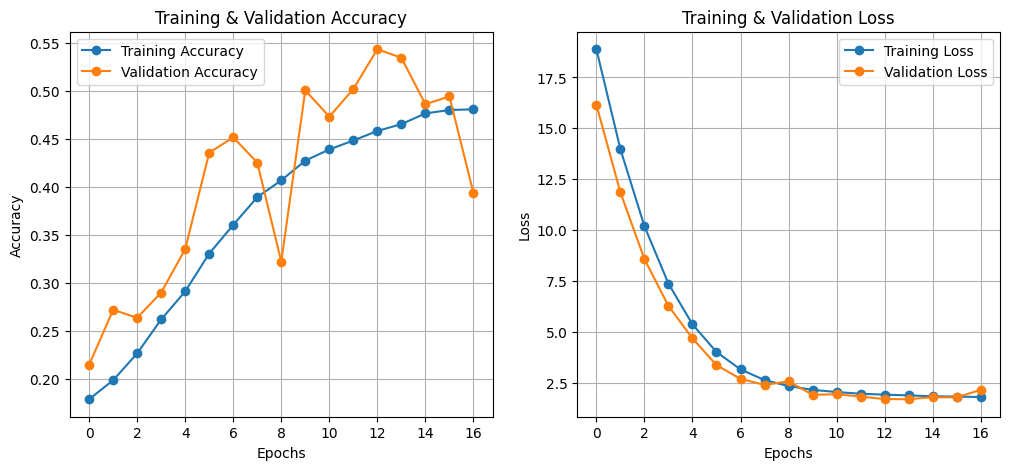

In [ ]:
# Plot Accuracy Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
from tensorflow.keras.models import load_model

emotion_model = load_model('emotion_model.keras')


In [ ]:
# Evaluate Model on Test Data
test_loss, test_acc = emotion_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.5614 - loss: 1.5535
Test Accuracy: 0.5857


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - accuracy: 0.5614 - loss: 1.5535
Test Accuracy: 0.5857, Test Loss: 1.5010


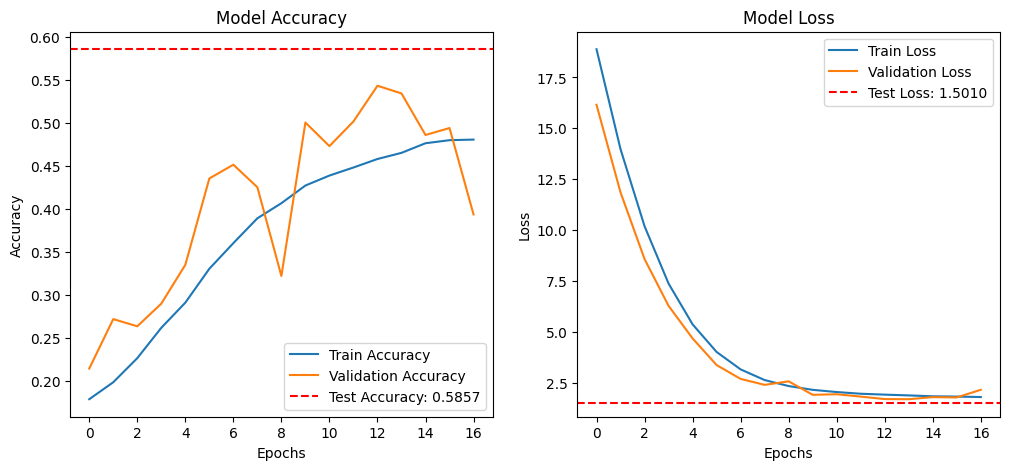

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = emotion_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

# Plot Accuracy and Loss Curves
def plot_model_performance(test_history, test_acc, test_loss):
    plt.figure(figsize=(12, 5))

    # Accuracy Graph
    plt.subplot(1, 2, 1)
    plt.plot(test_history.history['accuracy'], label='Train Accuracy')
    plt.plot(test_history.history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy: {test_acc:.4f}')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Graph
    plt.subplot(1, 2, 2)
    plt.plot(test_history.history['loss'], label='Train Loss')
    plt.plot(test_history.history['val_loss'], label='Validation Loss')
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the plotting function
plot_model_performance(history, test_acc, test_loss)

In [ ]:
# Train the model and store the history
history2 = emotion_model.fit(X_train, y_train, epochs=2, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/2
449/449 ━━━━━━━━━━━━━━━━━━━━ 151s 332ms/step - accuracy: 0.5853 - loss: 1.5517 - val_accuracy: 0.6096 - val_loss: 1.4408
Epoch 2/2
449/449 ━━━━━━━━━━━━━━━━━━━━ 148s 330ms/step - accuracy: 0.6590 - loss: 1.3321 - val_accuracy: 0.5857 - val_loss: 1.5010


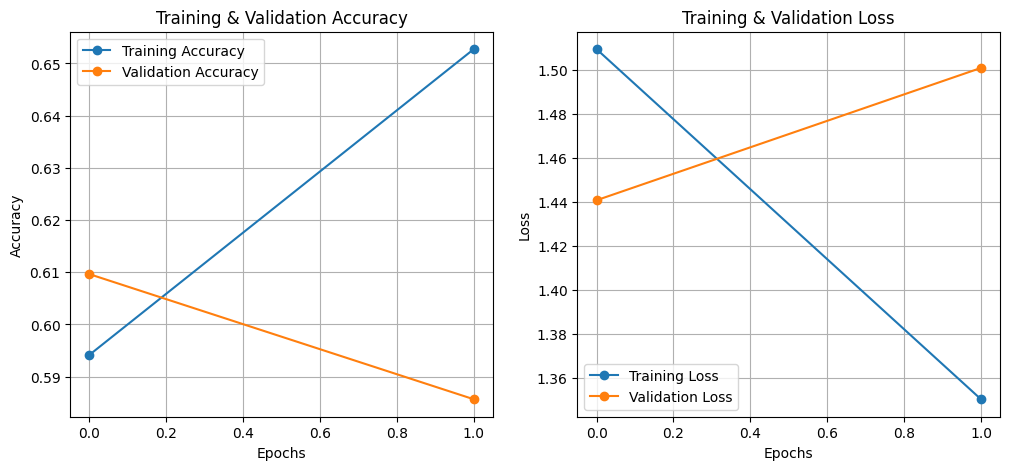

In [ ]:
# Plot Accuracy Graph
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss Graph
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Training Loss', marker='o')
plt.plot(history2.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

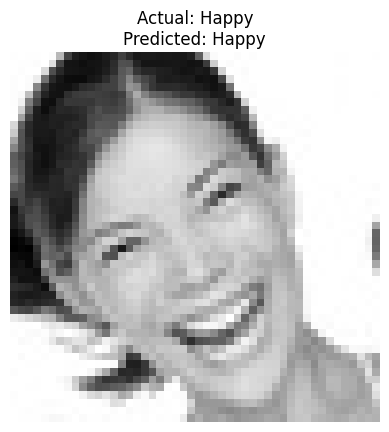

Actual Emotion: Happy
Predicted Emotion: Happy
Prediction Confidence: 0.9481


In [ ]:
# Function to predict and display emotion with actual label
def predict_emotion(index=None):
    if index is None:
        index = random.randint(0, len(X_test) - 1)  # Random image if no index provided

    # Prepare the image for prediction
    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image, verbose=0)

    # Get predicted and actual labels
    predicted_label = emotion_labels[np.argmax(prediction)]
    actual_label = emotion_labels[np.argmax(y_test[index])]

    # Display the image with prediction and actual label
    plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
    plt.axis("off")
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.show()

    print(f"Actual Emotion: {actual_label}")
    print(f"Predicted Emotion: {predicted_label}")
    print(f"Prediction Confidence: {prediction[0][np.argmax(prediction)]:.4f}")

predict_emotion()

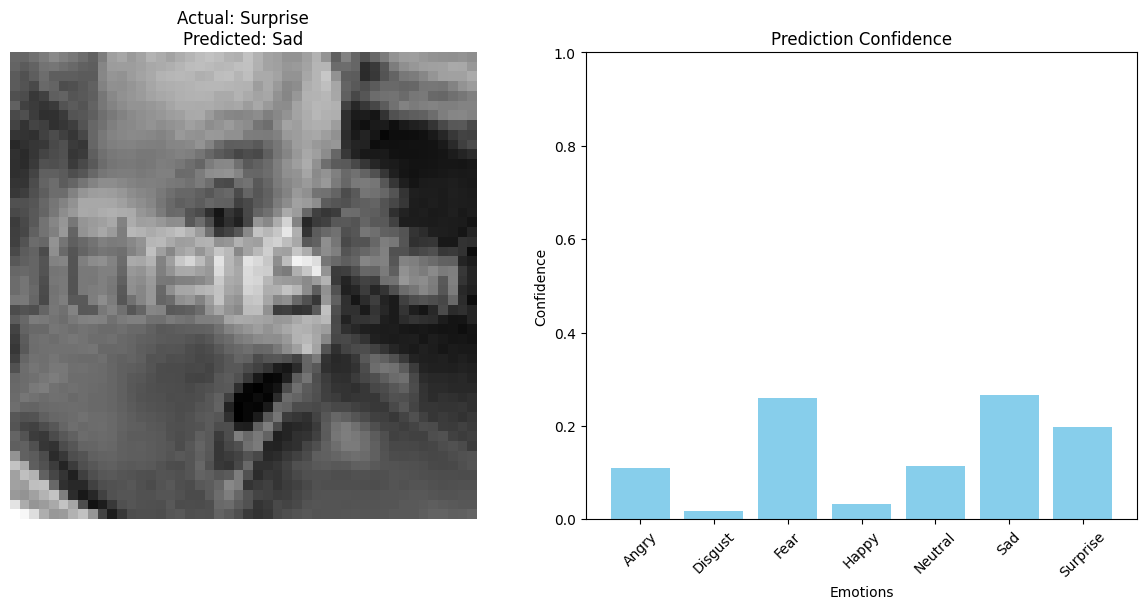

Actual Emotion: Surprise
Predicted Emotion: Sad
Confidence Scores: {'Angry': 0.109447666, 'Disgust': 0.018591369, 'Fear': 0.26082364, 'Happy': 0.032231, 'Neutral': 0.113896765, 'Sad': 0.2668951, 'Surprise': 0.1981144}


In [ ]:
# Function to predict emotion and display confidence bar chart
def predict_emotion_with_confidence(index=None):
    if index is None:
        index = random.randint(0, len(X_test) - 1)  # Select random image if no index is provided

    # Prepare the image for prediction
    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image, verbose=0)

    # Get predicted and actual labels
    predicted_label = emotion_labels[np.argmax(prediction)]
    actual_label = emotion_labels[np.argmax(y_test[index])]

    # Display the image
    plt.figure(figsize=(12, 6))

    # Image subplot
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
    plt.axis("off")
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

    # Bar plot for confidence levels
    plt.subplot(1, 2, 2)
    plt.bar(emotion_labels, prediction[0], color='skyblue')
    plt.ylabel("Confidence")
    plt.xlabel("Emotions")
    plt.title("Prediction Confidence")
    plt.ylim(0, 1)  # Confidence ranges from 0 to 1
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    print(f"Actual Emotion: {actual_label}")
    print(f"Predicted Emotion: {predicted_label}")
    print(f"Confidence Scores: {dict(zip(emotion_labels, prediction[0]))}")

# Call the function to predict and visualize
predict_emotion_with_confidence()

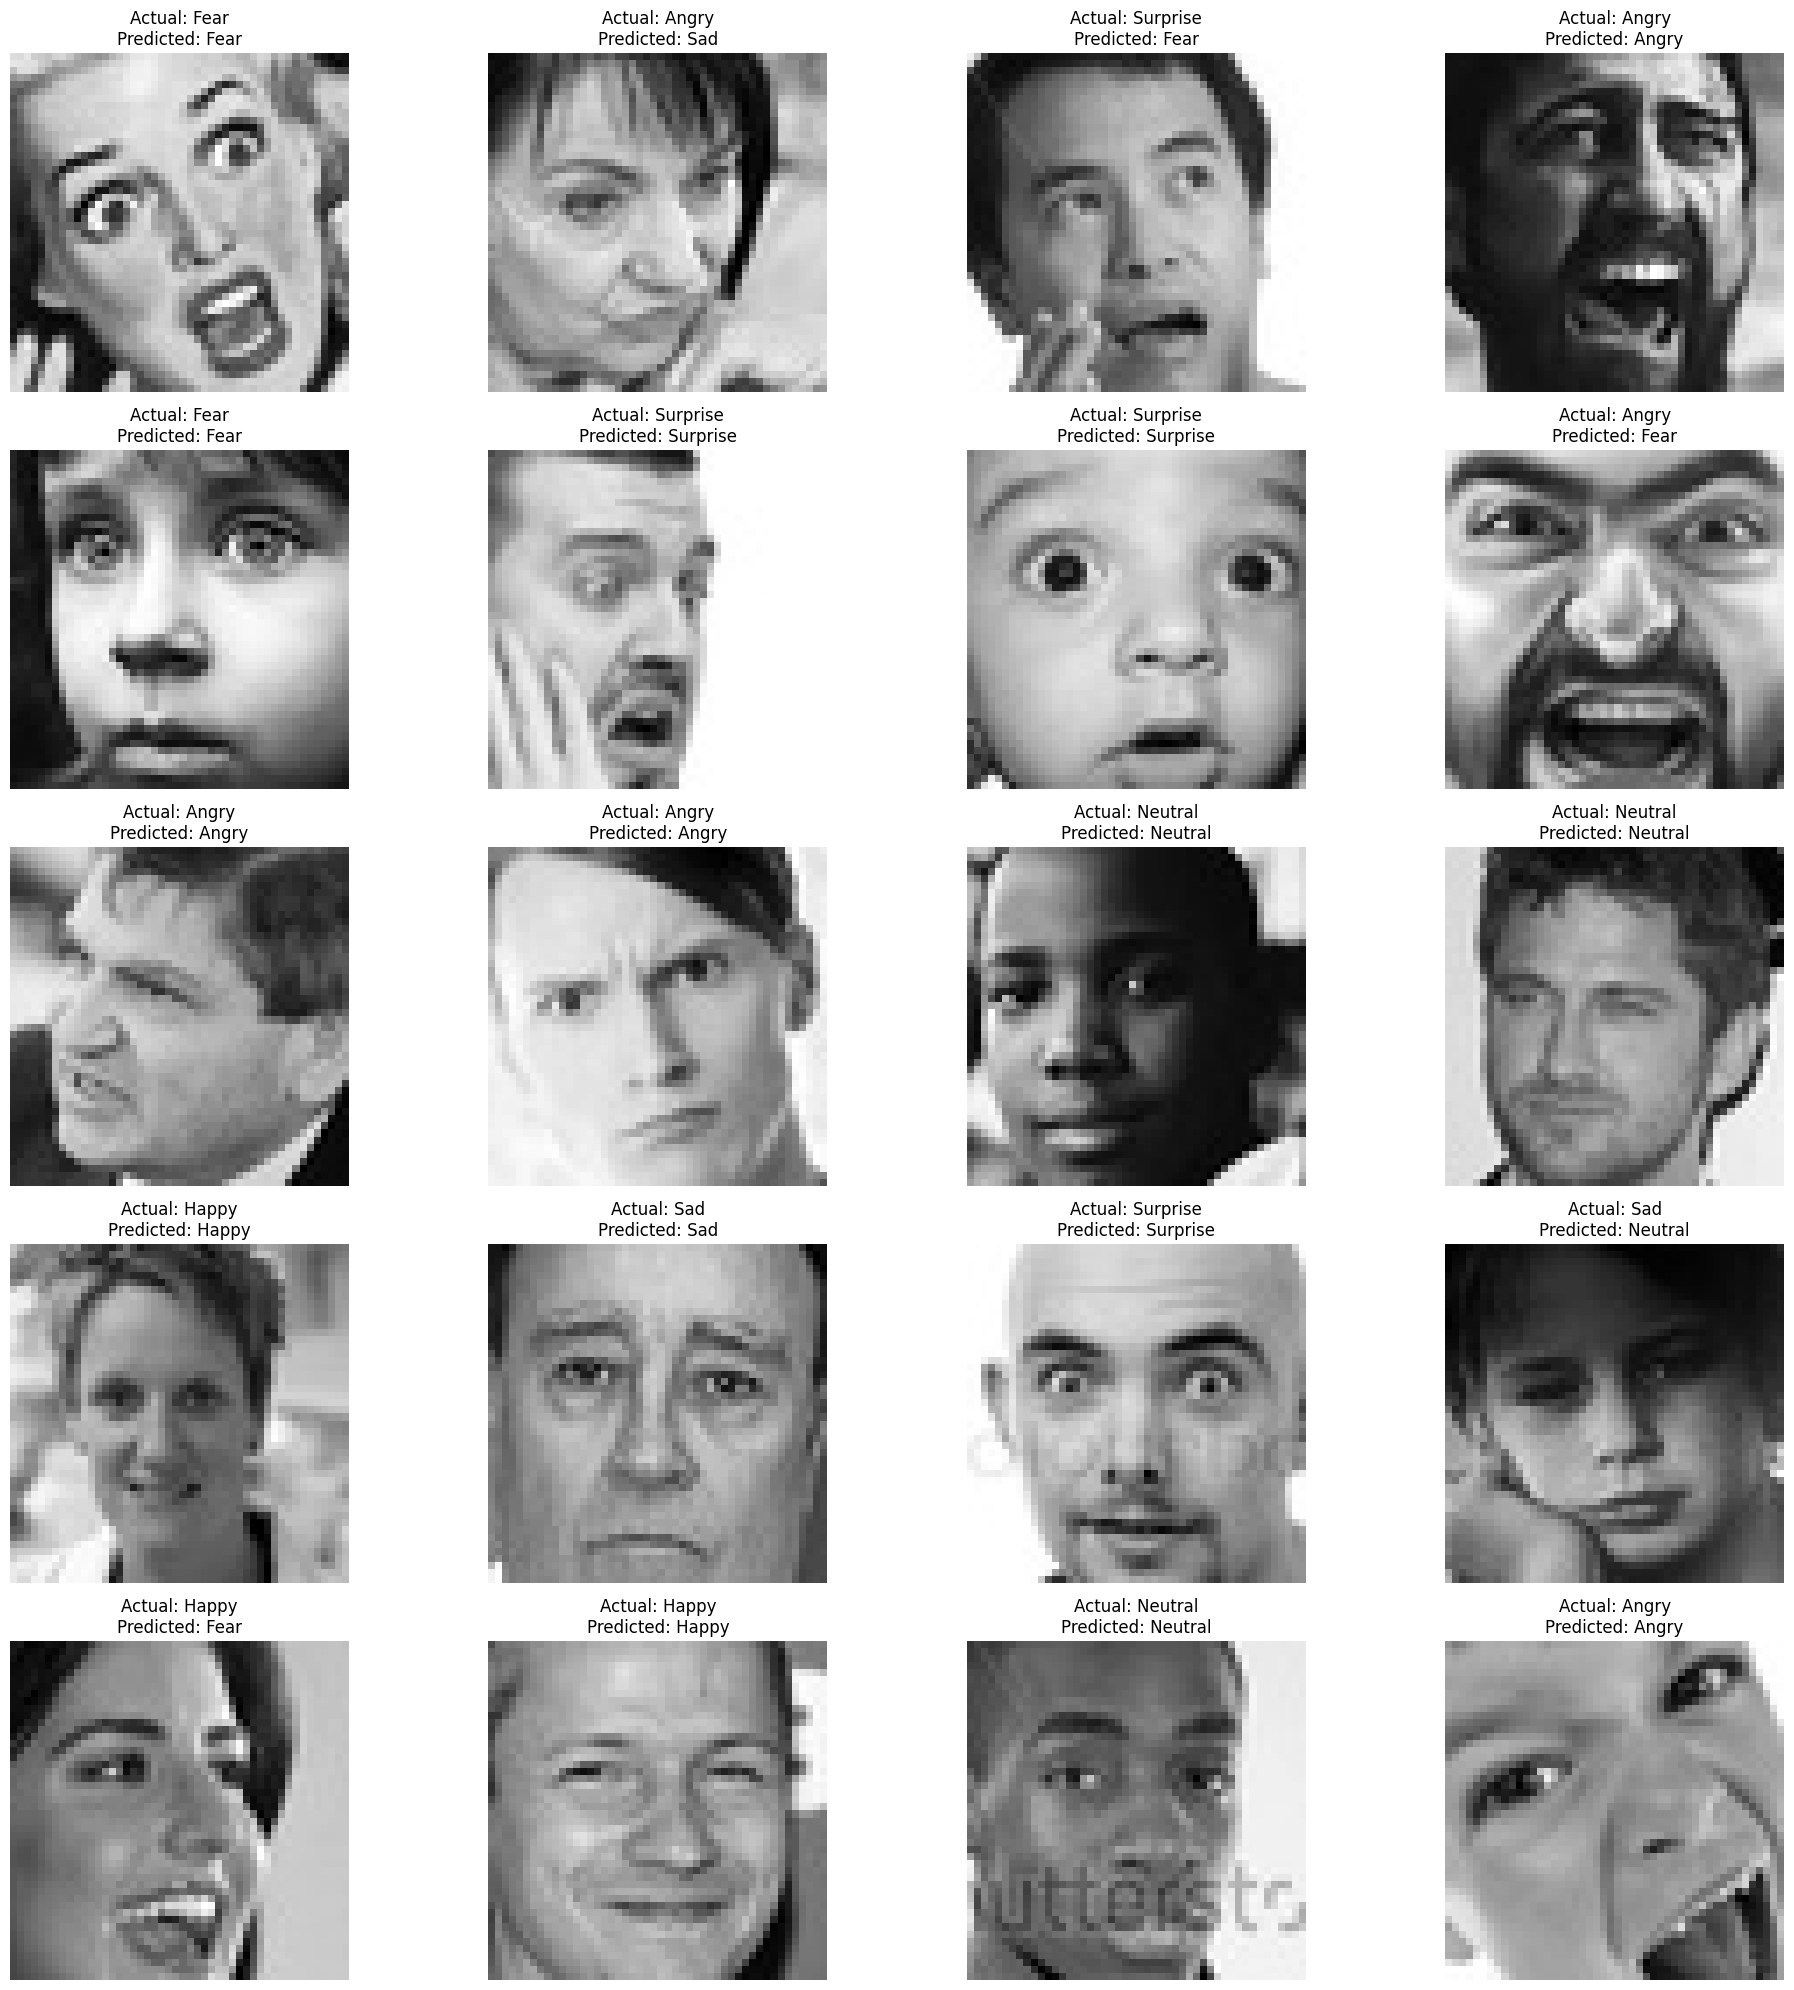

In [ ]:
# Function to predict and display 20 random images with actual and predicted emotions
def predict_multiple_emotions(num_images=20):
    plt.figure(figsize=(20, 20))

    for i in range(num_images):
        # Select a random index from the test set
        index = random.randint(0, len(X_test) - 1)

        # Prepare the image for prediction
        test_image = np.expand_dims(X_test[index], axis=0)
        prediction = emotion_model.predict(test_image, verbose=0)
        
        # Get predicted and actual labels
        predicted_label = emotion_labels[np.argmax(prediction)]
        actual_label = emotion_labels[np.argmax(y_test[index])]

        # Display the image with predictions
        plt.subplot(5, 4, i + 1)
        plt.imshow(X_test[index].reshape(48, 48), cmap='gray')
        plt.axis("off")
        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

    plt.tight_layout()
    plt.show()

# Call the function to display 20 images with actual and predicted emotions
predict_multiple_emotions()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


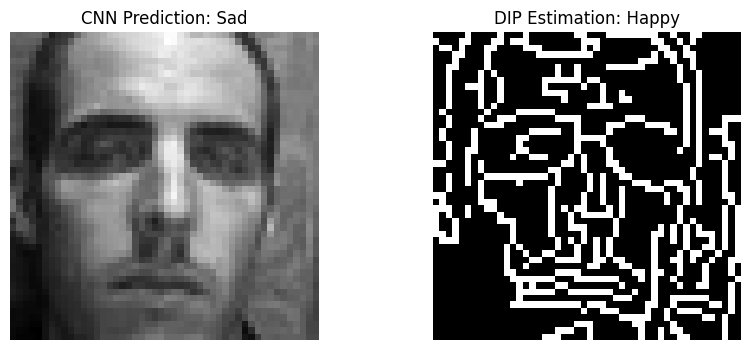

📌 CNN Model Predicted: Sad
📌 DIP-Based Estimation: Happy


In [ ]:
def dip_based_estimation(gray_img):
    """Estimate emotion using basic DIP techniques."""
    edges = cv2.Canny(gray_img, 50, 150)  # Apply Canny Edge Detection
    mean_intensity = np.mean(gray_img)  # Average brightness
    edge_count = np.sum(edges > 100)  # Count strong edges

    # Simple rule-based emotion classification
    if edge_count > 1500 and mean_intensity < 80:
        return "Angry"
    elif edge_count < 500 and mean_intensity > 150:
        return "Neutral"
    elif edge_count > 1800:
        return "Surprise"
    elif mean_intensity < 50:
        return "Sad"
    else:
        return "Happy"

def predict_emotion(index=None):
    """Predict emotion using CNN and compare with DIP-based estimation."""
    if index is None:
        index = random.randint(0, len(X_test) - 1)

    test_image = np.expand_dims(X_test[index], axis=0)  # Add batch dimension
    prediction = emotion_model.predict(test_image)
    cnn_predicted_label = emotion_labels[np.argmax(prediction)]

    # Convert image to grayscale for DIP processing
    gray_img = X_test[index].reshape(48, 48) * 255  # Convert back to 8-bit range
    dip_predicted_label = dip_based_estimation(gray_img.astype(np.uint8))

    # Display results
    plt.figure(figsize=(10, 4))

    # CNN Prediction
    plt.subplot(1, 2, 1)
    plt.imshow(gray_img, cmap='gray')
    plt.axis("off")
    plt.title(f"CNN Prediction: {cnn_predicted_label}")

    # DIP Prediction
    edges = cv2.Canny(gray_img.astype(np.uint8), 50, 150)
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title(f"DIP Estimation: {dip_predicted_label}")

    plt.show()

    # Print comparison
    print(f"📌 CNN Model Predicted: {cnn_predicted_label}")
    print(f"📌 DIP-Based Estimation: {dip_predicted_label}")

# Run on a random image
predict_emotion()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


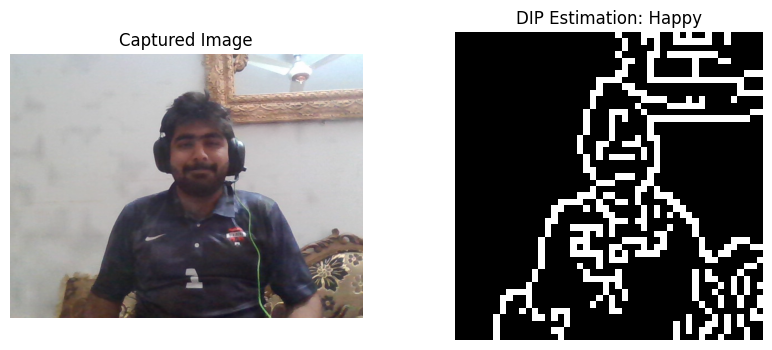

📌 CNN Model Predicted: Fear
📌 DIP-Based Estimation: Happy


In [ ]:
def capture_image():
    """Capture an image from the webcam."""
    cap = cv2.VideoCapture(0)  # Open webcam
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    ret, frame = cap.read()  # Capture frame
    cap.release()  # Release webcam
    if not ret:
        print("Error: Could not capture image.")
        return None

    return frame

def preprocess_image(frame):
    """Convert to grayscale, resize to 48x48, and normalize."""
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_img = cv2.resize(gray_img, (48, 48))  # Resize to (48x48)
    normalized_img = resized_img / 255.0  # Normalize pixel values (0-1)
    return np.expand_dims(normalized_img, axis=(0, -1))  # Add batch & channel dims

def dip_based_estimation(gray_img):
    """Estimate emotion using basic DIP techniques."""
    gray_img = gray_img.astype(np.uint8)  # Convert to uint8 (0-255)
    
    edges = cv2.Canny(gray_img, 50, 150)  # Apply Canny Edge Detection
    mean_intensity = np.mean(gray_img)  # Average brightness
    edge_count = np.sum(edges > 100)  # Count strong edges

    # Simple rule-based emotion classification
    if edge_count > 1500 and mean_intensity < 80:
        return "Angry"
    elif edge_count < 500 and mean_intensity > 150:
        return "Neutral"
    elif edge_count > 1800:
        return "Surprise"
    elif mean_intensity < 50:
        return "Sad"
    else:
        return "Happy"

def predict_webcam_emotion():
    """Capture, preprocess, and predict emotion from a webcam image."""
    frame = capture_image()
    if frame is None:
        return

    # Preprocess image
    preprocessed_img = preprocess_image(frame)

    # CNN Prediction
    prediction = emotion_model.predict(preprocessed_img)
    cnn_predicted_label = emotion_labels[np.argmax(prediction)]

    # DIP Prediction
    dip_predicted_label = dip_based_estimation(preprocessed_img[0, :, :, 0] * 255)

    # Display Results
    plt.figure(figsize=(10, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Captured Image")

    # DIP Edge Detection
    edges = cv2.Canny((preprocessed_img[0, :, :, 0] * 255).astype(np.uint8), 50, 150)
    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title(f"DIP Estimation: {dip_predicted_label}")

    plt.show()

    # Print Predictions
    print(f"📌 CNN Model Predicted: {cnn_predicted_label}")
    print(f"📌 DIP-Based Estimation: {dip_predicted_label}")

# Run webcam-based emotion prediction
predict_webcam_emotion()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


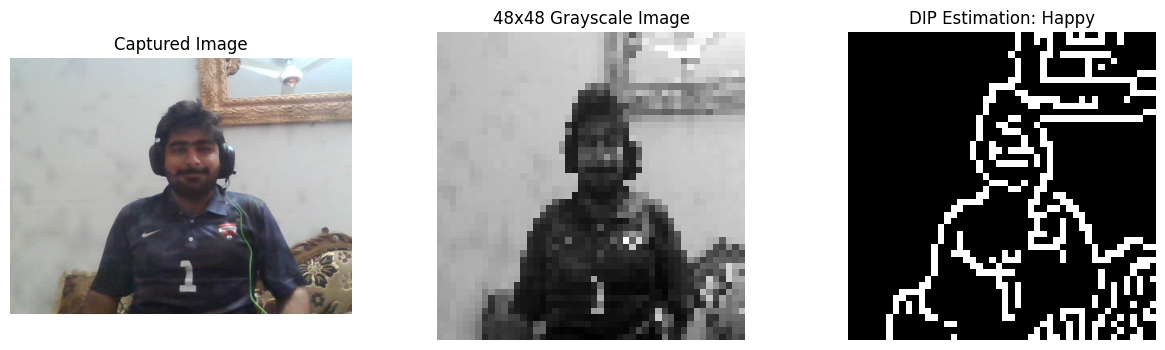

📌 CNN Model Predicted: Fear
📌 DIP-Based Estimation: Happy


In [ ]:
def capture_image():
    """Capture an image from the webcam."""
    cap = cv2.VideoCapture(0)  # Open webcam
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    ret, frame = cap.read()  # Capture frame
    cap.release()  # Release webcam
    if not ret:
        print("Error: Could not capture image.")
        return None

    return frame

def preprocess_image(frame):
    """Convert to grayscale, resize to 48x48, and normalize."""
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_img = cv2.resize(gray_img, (48, 48))  # Resize to (48x48)
    normalized_img = resized_img / 255.0  # Normalize pixel values (0-1)
    return np.expand_dims(normalized_img, axis=(0, -1))  # Add batch & channel dims

def dip_based_estimation(gray_img):
    """Estimate emotion using basic DIP techniques."""
    gray_img = gray_img.astype(np.uint8)  # Convert to uint8 (0-255)

    edges = cv2.Canny(gray_img, 50, 150)  # Apply Canny Edge Detection
    mean_intensity = np.mean(gray_img)  # Average brightness
    edge_count = np.sum(edges > 100)  # Count strong edges

    # Simple rule-based emotion classification
    if edge_count > 1500 and mean_intensity < 80:
        return "Angry"
    elif edge_count < 500 and mean_intensity > 150:
        return "Neutral"
    elif edge_count > 1800:
        return "Surprise"
    elif mean_intensity < 50:
        return "Sad"
    else:
        return "Happy"

def predict_webcam_emotion():
    """Capture, preprocess, and predict emotion from a webcam image."""
    frame = capture_image()
    if frame is None:
        return

    # Preprocess image
    preprocessed_img = preprocess_image(frame)

    # CNN Prediction
    prediction = emotion_model.predict(preprocessed_img)
    cnn_predicted_label = emotion_labels[np.argmax(prediction)]

    # DIP Prediction
    dip_predicted_label = dip_based_estimation(preprocessed_img[0, :, :, 0] * 255)

    # Display Results
    plt.figure(figsize=(15, 4))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Captured Image")

    # Grayscale 48x48 Image
    plt.subplot(1, 3, 2)
    plt.imshow(preprocessed_img[0, :, :, 0], cmap='gray')
    plt.axis("off")
    plt.title("48x48 Grayscale Image")

    # DIP Edge Detection
    edges = cv2.Canny((preprocessed_img[0, :, :, 0] * 255).astype(np.uint8), 50, 150)
    plt.subplot(1, 3, 3)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title(f"DIP Estimation: {dip_predicted_label}")

    plt.show()

    # Print Predictions
    print(f"📌 CNN Model Predicted: {cnn_predicted_label}")
    print(f"📌 DIP-Based Estimation: {dip_predicted_label}")

# Run webcam-based emotion prediction
predict_webcam_emotion()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


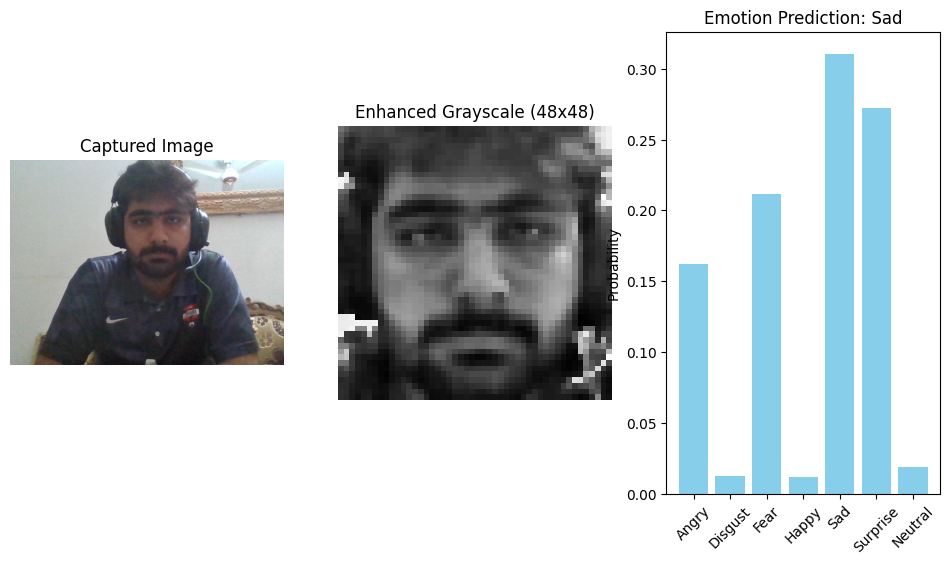

📌 Predicted Emotion: Sad


In [ ]:
def capture_image():
    """Capture an image from the webcam."""
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Error: Could not capture image.")
        return None

    return frame

def detect_face(frame):
    """Detect and crop face region using Haar Cascade."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)

    if len(faces) == 0:
        print("No face detected. Using full image.")
        return frame

    (x, y, w, h) = faces[0]
    return frame[y:y + h, x:x + w]

def preprocess_image(frame):
    """Enhance image for better emotion detection."""
    face = detect_face(frame)

    # Apply bilateral filter for edge preservation
    enhanced_img = cv2.bilateralFilter(face, d=9, sigmaColor=75, sigmaSpace=75)

    # Convert to grayscale
    gray_img = cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray_img)

    # Resize using bicubic interpolation for better clarity
    resized_img = cv2.resize(enhanced_gray, (48, 48), interpolation=cv2.INTER_CUBIC)

    # Normalize pixel values to 0-1
    normalized_img = resized_img / 255.0

    return np.expand_dims(normalized_img, axis=(0, -1)), resized_img

def predict_emotion(model, processed_img, emotion_labels):
    """Predict emotion and return label with probabilities."""
    predictions = model.predict(processed_img)
    predicted_label = emotion_labels[np.argmax(predictions)]
    return predicted_label, predictions[0]

def main():
    # Load your pre-trained model here
    # Example: emotion_model = load_model('emotion_model.h5')

    # Emotion labels (adjust according to your model)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

    frame = capture_image()
    if frame is None:
        return

    processed_img, enhanced_gray = preprocess_image(frame)

    # Predict emotion
    predicted_label, probabilities = predict_emotion(emotion_model, processed_img, emotion_labels)

    # Display results
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Captured Image")

    # Enhanced Grayscale Image (48x48)
    plt.subplot(1, 3, 2)
    plt.imshow(enhanced_gray, cmap='gray')
    plt.axis("off")
    plt.title("Enhanced Grayscale (48x48)")

    # Emotion Prediction Bar Graph
    plt.subplot(1, 3, 3)
    plt.bar(emotion_labels, probabilities, color='skyblue')
    plt.title(f"Emotion Prediction: {predicted_label}")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)

    plt.show()

    print(f"📌 Predicted Emotion: {predicted_label}")

if __name__ == "__main__":
    main()

✅ Preprocessed image shape: (1, 48, 48, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


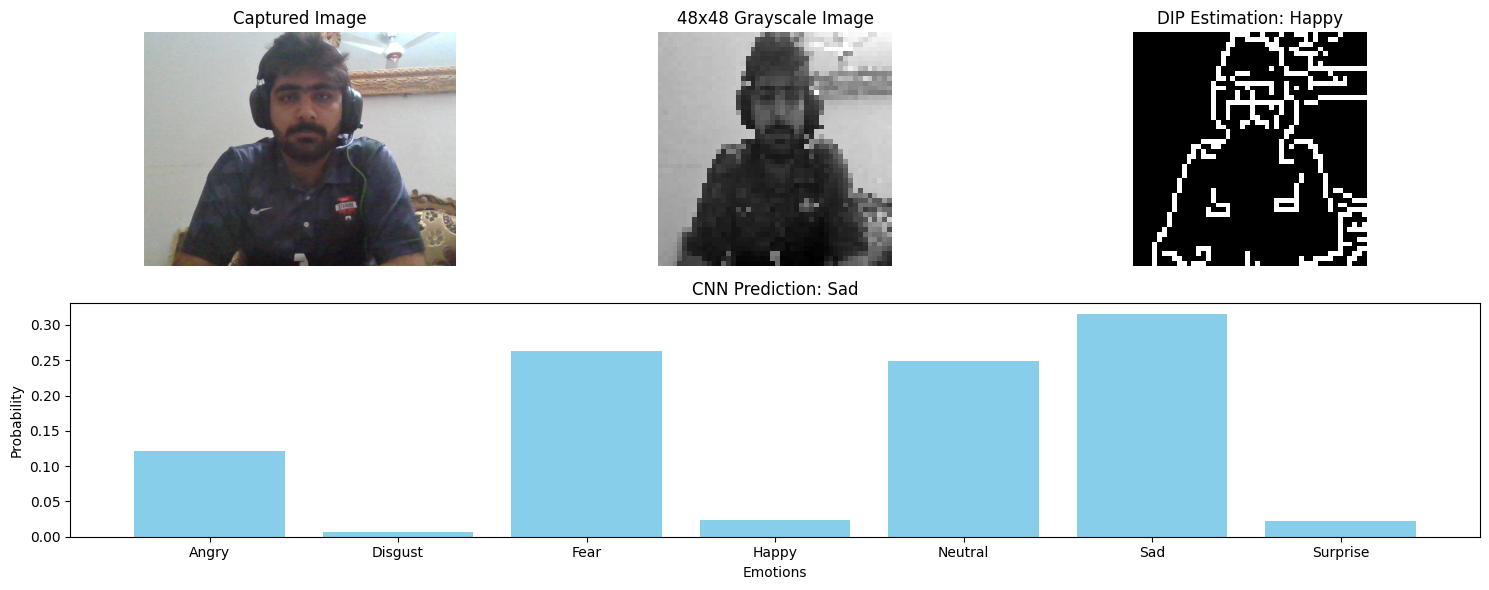

📌 CNN Model Predicted: Sad
📌 DIP-Based Estimation: Happy


In [ ]:
def capture_image():
    """Capture an image from the webcam."""
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("Error: Could not capture image.")
        return None

    return frame

def preprocess_image(frame):
    """Preprocess image: Convert to 48x48 grayscale and normalize."""
    gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    resized_img = cv2.resize(gray_img, (48, 48))  # Resize to (48x48)
    
    # Normalize and expand dimensions to match CNN input shape
    normalized_img = resized_img / 255.0
    processed_img = np.expand_dims(normalized_img, axis=(0, -1))  # Shape: (1, 48, 48, 1)

    print(f"✅ Preprocessed image shape: {processed_img.shape}")  # Debugging output
    return processed_img

def dip_based_estimation(gray_img):
    """Estimate emotion using basic DIP techniques."""
    gray_img = gray_img.astype(np.uint8)
    edges = cv2.Canny(gray_img, 50, 150)  # Edge Detection
    mean_intensity = np.mean(gray_img)  # Brightness
    edge_count = np.sum(edges > 100)  # Strong Edges

    if edge_count > 1500 and mean_intensity < 80:
        return "Angry"
    elif edge_count < 500 and mean_intensity > 150:
        return "Neutral"
    elif edge_count > 1800:
        return "Surprise"
    elif mean_intensity < 50:
        return "Sad"
    else:
        return "Happy"

def predict_webcam_emotion_with_bar():
    """Capture, preprocess, and predict emotion from webcam with a bar graph."""
    frame = capture_image()
    if frame is None:
        return

    # Preprocess image
    preprocessed_img = preprocess_image(frame)

    # Ensure the model is defined and labels exist
    global emotion_model, emotion_labels
    if 'emotion_model' not in globals() or 'emotion_labels' not in globals():
        print("Error: Ensure 'emotion_model' and 'emotion_labels' are defined.")
        return

    # CNN Prediction (Ensure shape consistency)
    prediction = emotion_model.predict(preprocessed_img)[0]
    cnn_predicted_label = emotion_labels[np.argmax(prediction)]

    # DIP Prediction
    dip_predicted_label = dip_based_estimation(preprocessed_img[0, :, :, 0] * 255)

    # Display Results
    plt.figure(figsize=(15, 6))

    # Original Image
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Captured Image")

    # Grayscale 48x48 Image
    plt.subplot(2, 3, 2)
    plt.imshow(preprocessed_img[0, :, :, 0], cmap='gray')
    plt.axis("off")
    plt.title("48x48 Grayscale Image")

    # DIP Edge Detection
    edges = cv2.Canny((preprocessed_img[0, :, :, 0] * 255).astype(np.uint8), 50, 150)
    plt.subplot(2, 3, 3)
    plt.imshow(edges, cmap='gray')
    plt.axis("off")
    plt.title(f"DIP Estimation: {dip_predicted_label}")

    # Bar Graph of CNN Predictions
    plt.subplot(2, 1, 2)
    plt.bar(emotion_labels, prediction, color='skyblue')
    plt.xlabel("Emotions")
    plt.ylabel("Probability")
    plt.title(f"CNN Prediction: {cnn_predicted_label}")

    plt.tight_layout()
    plt.show()

    # Print Predictions
    print(f"📌 CNN Model Predicted: {cnn_predicted_label}")
    print(f"📌 DIP-Based Estimation: {dip_predicted_label}")

# Ensure you have a loaded model and labels
# emotion_model = keras.models.load_model("your_emotion_model.h5")
# emotion_labels = ["Angry", "Happy", "Neutral", "Sad", "Surprise"]

# Run webcam-based emotion prediction with bar chart
predict_webcam_emotion_with_bar()


In [ ]:
# Emotion labels (ensure this matches your model's output order)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Sliding window for stability (increase to 15 for better smoothing)
prediction_window = deque(maxlen=15)

# Adaptive confidence thresholds
emotion_thresholds = {
    'Angry': 0.3,
    'Fear': 0.3,
    'Sad': 0.3,
    'Happy': 0.7,
    'Neutral': 0.85,
    'Surprise': 0.6,
    'Disgust': 0.5
}

# Weights for underrepresented emotions (higher values = better detection)
emotion_weights = {
    'Angry': 1.8,
    'Fear': 1.8,
    'Sad': 1.8,
    'Happy': 1.0,
    'Neutral': .05,
    'Surprise': 1.8,
    'Disgust': 1.8
}

# Load Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def preprocess_image(face):
    """Preprocess face for CNN input (grayscale, resize, normalize)."""
    gray_face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    resized_face = cv2.resize(gray_face, (48, 48))
    normalized_face = resized_face / 255.0
    return np.expand_dims(normalized_face, axis=(0, -1))

def get_smoothed_prediction():
    """Return the most frequent emotion with weighted votes."""
    if not prediction_window:
        return "Unknown"
    # Apply weights to underrepresented emotions
    weighted_votes = {}
    for emotion in prediction_window:
        weighted_votes[emotion] = weighted_votes.get(emotion, 0) + emotion_weights.get(emotion, 1)
    return max(weighted_votes, key=weighted_votes.get)

def live_face_emotion():
    """Perform live emotion detection with dynamic thresholds and stability."""
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Detect faces
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(100, 100))

        for (x, y, w, h) in faces:
            face = frame[y:y+h, x:x+w]

            # Draw bounding box around the detected face
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

            # Process every 3rd frame for better responsiveness
            if frame_count % 3 == 0:
                preprocessed_face = preprocess_image(face)
                prediction = emotion_model.predict(preprocessed_face)
                predicted_label = emotion_labels[np.argmax(prediction)]
                confidence = np.max(prediction)

                # Dynamic confidence adjustment
                required_confidence = emotion_thresholds.get(predicted_label, 0.5)

                # Lower the confidence threshold for difficult emotions dynamically
                if predicted_label in ['Angry', 'Fear', 'Sad']:
                    required_confidence *= 0.8  # Make it easier for these emotions

                if confidence > required_confidence:
                    prediction_window.append(predicted_label)

            # Display the stabilized prediction
            stable_emotion = get_smoothed_prediction()
            cv2.putText(frame, f"Emotion: {stable_emotion}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        frame_count += 1

        # Display the live feed
        cv2.imshow("Live Emotion Detection", frame)

        # Exit on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Start the live detection
live_face_emotion()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
